In [1]:
cd /home

/home


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [3]:
def sample_lc(sequence, max_obs):
    '''
    Sample a random window of "max_obs" observations from the input sequence
    '''
    serie_len = tf.shape(sequence)[0]

    pivot = 0
    if tf.greater(serie_len, max_obs):
        pivot = tf.random.uniform([],
                                  minval=0,
                                  maxval=serie_len-max_obs+1,
                                  dtype=tf.int32)

        sequence = tf.slice(sequence, [pivot,0], [max_obs, -1])
    else:
        sequence = tf.slice(sequence, [0,0], [serie_len, -1])

    return sequence

In [4]:
times = tf.range(0, 15, dtype=tf.float32)
magnitudes = tf.sin(times)
sequence = tf.transpose(tf.stack([times, magnitudes], 0))

2021-11-13 21:13:21.018708: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: UNKNOWN ERROR (34)
2021-11-13 21:13:21.018748: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (153b5d94f976): /proc/driver/nvidia/version does not exist
2021-11-13 21:13:21.019032: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


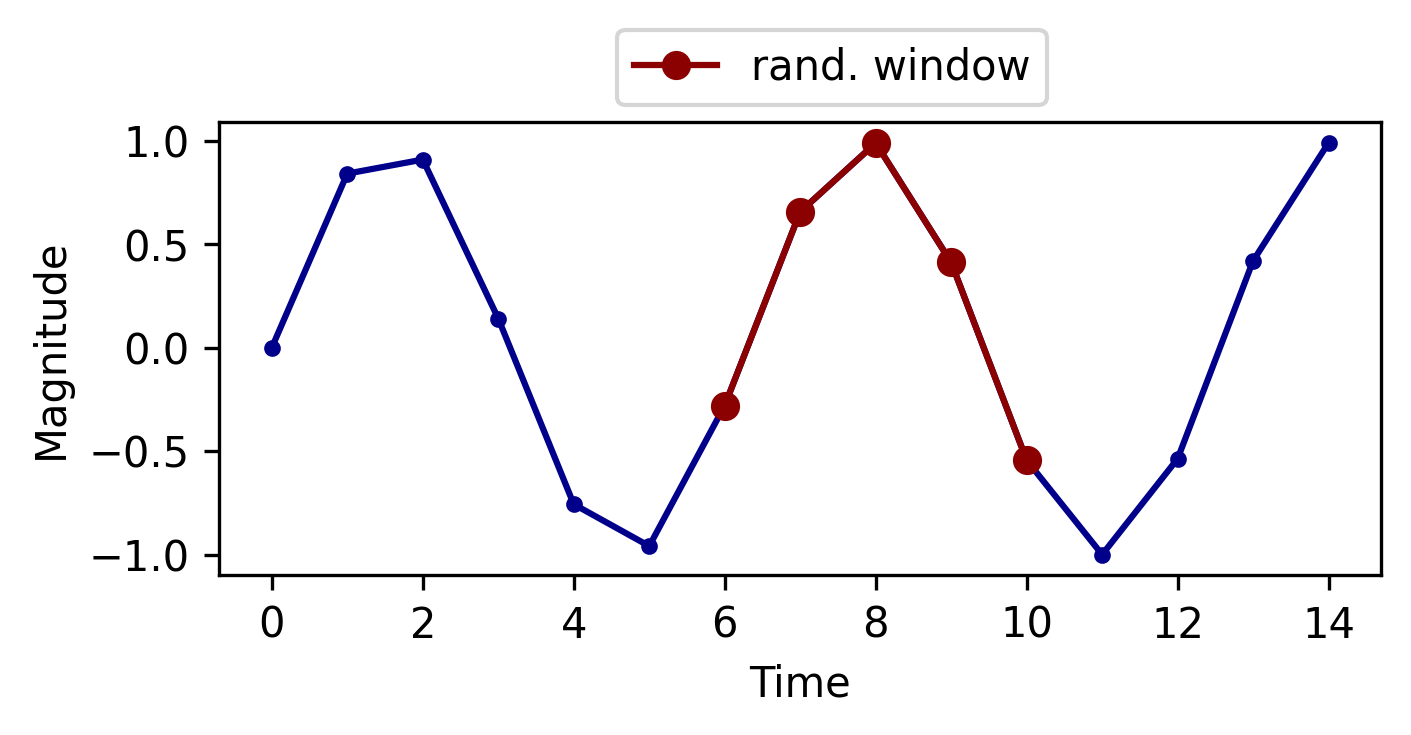

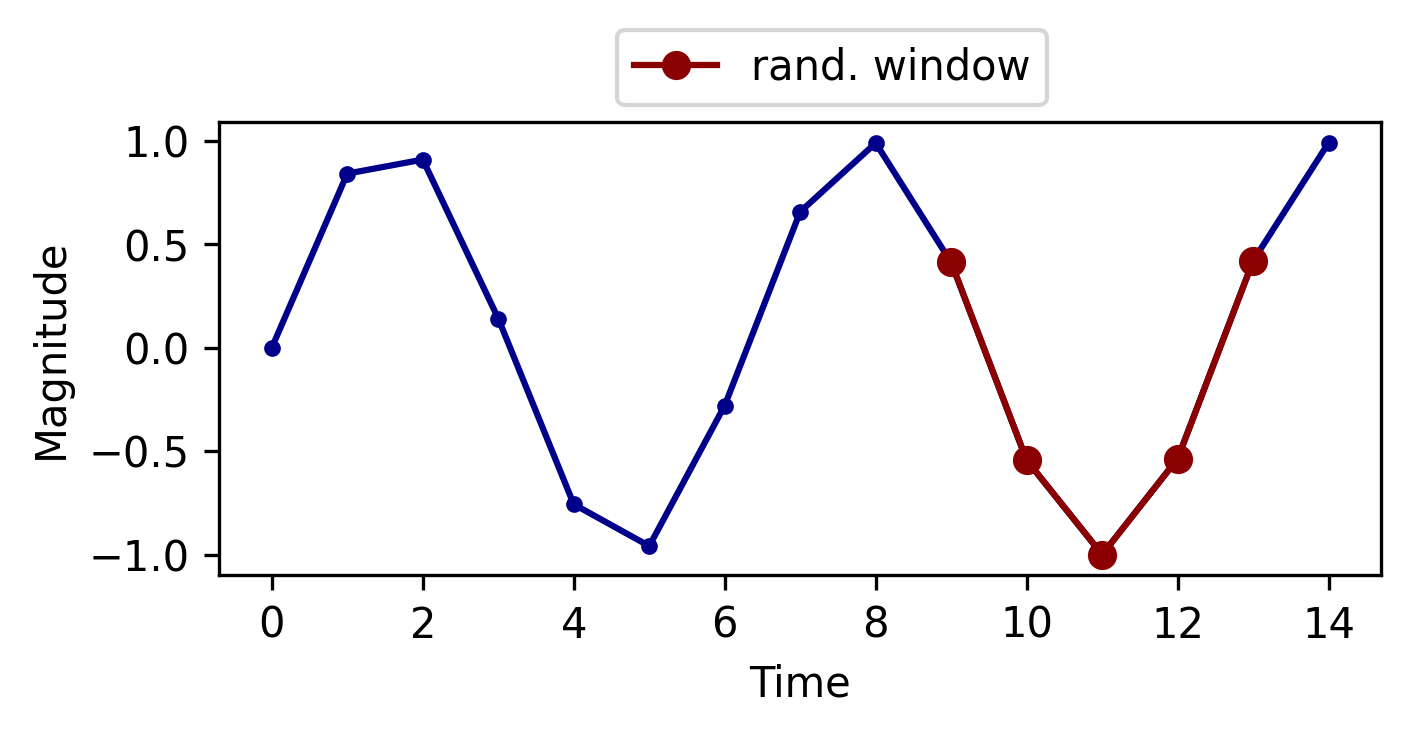

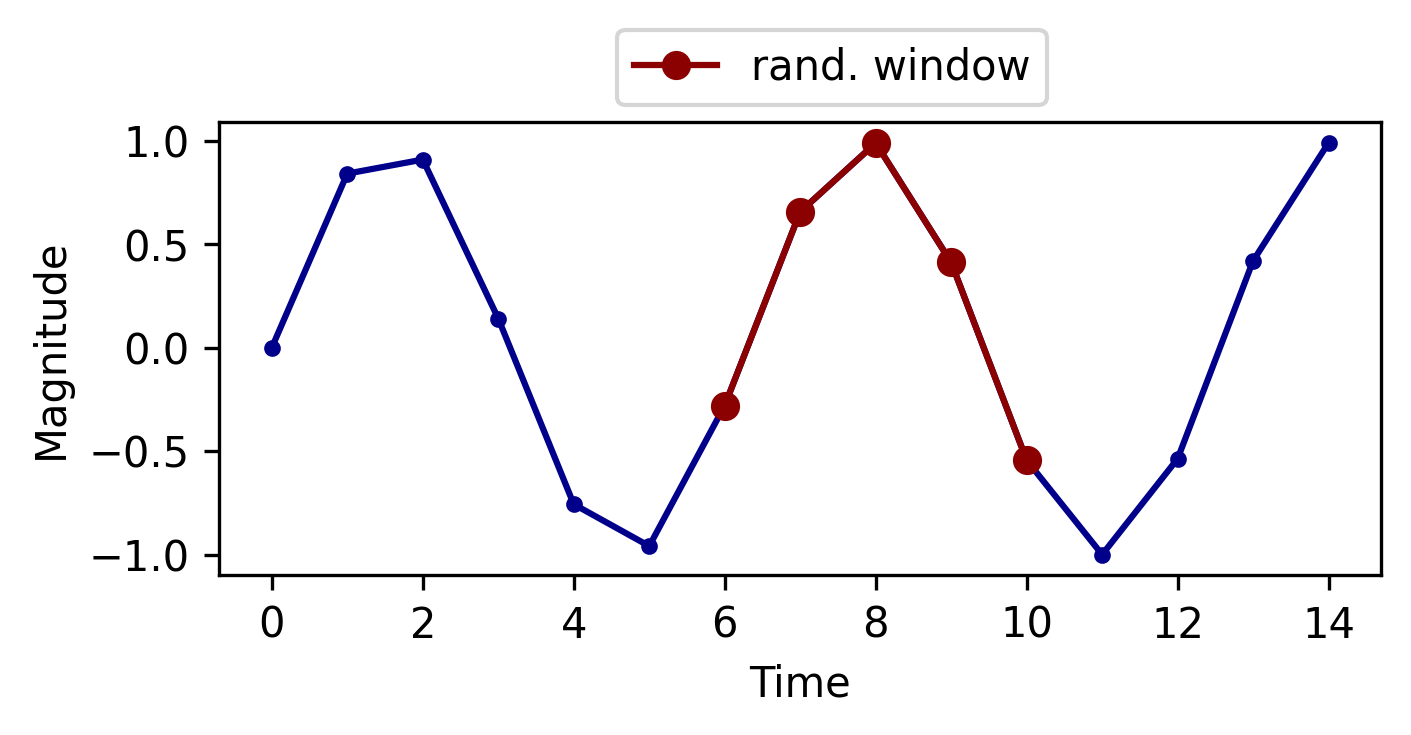

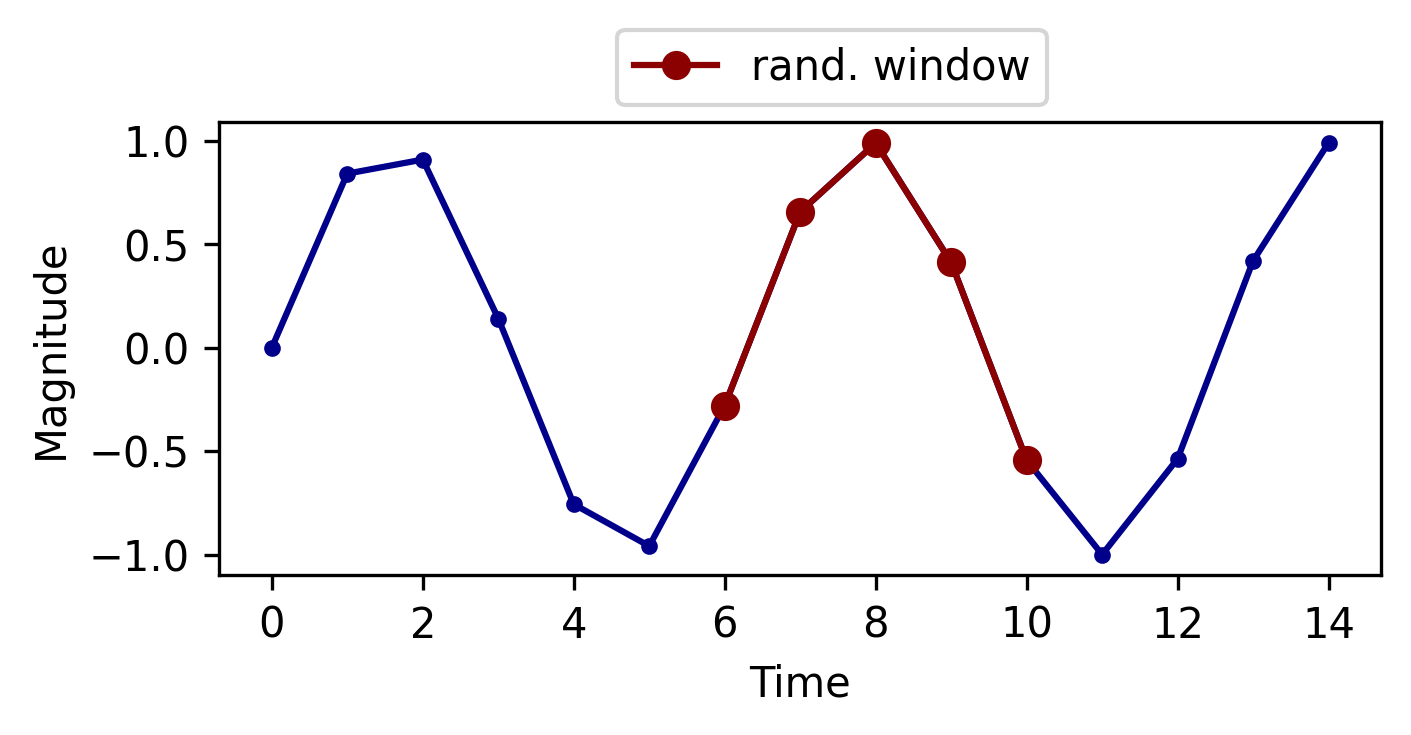

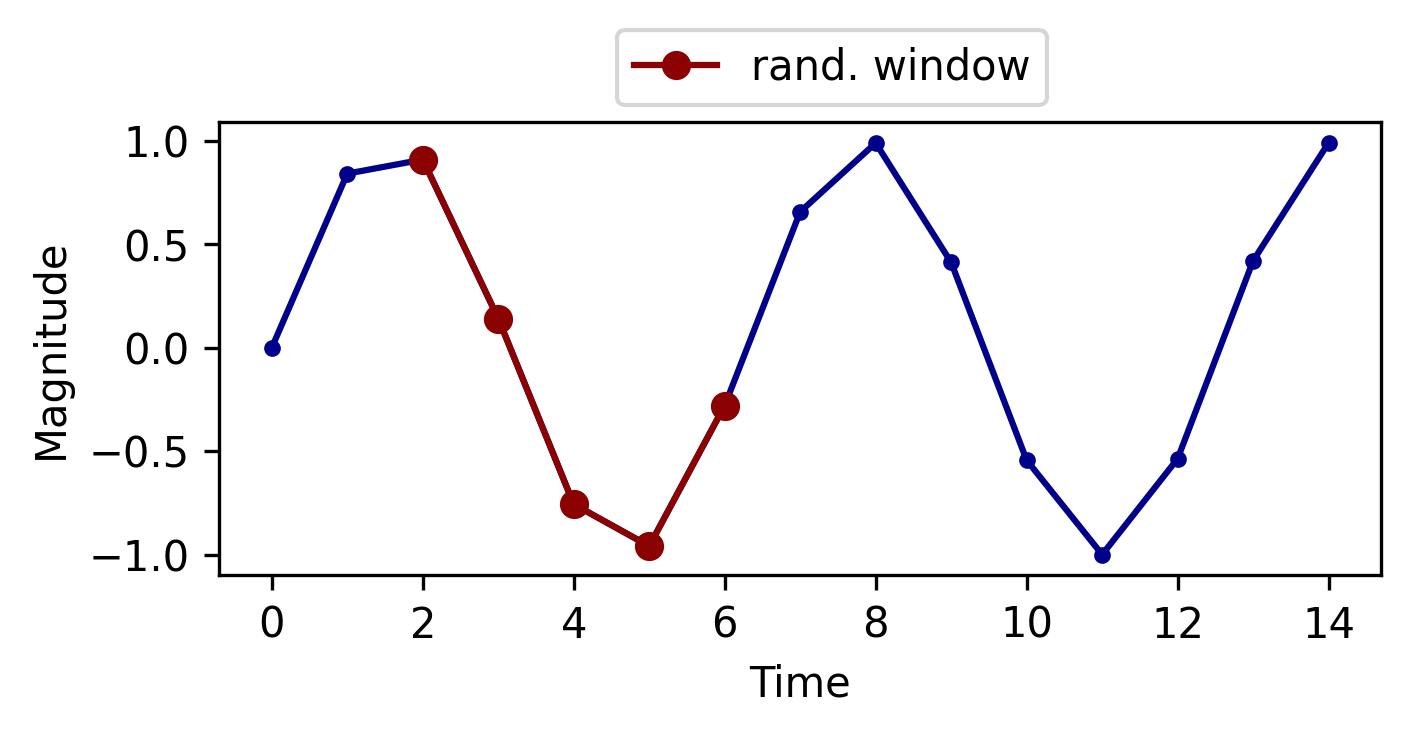

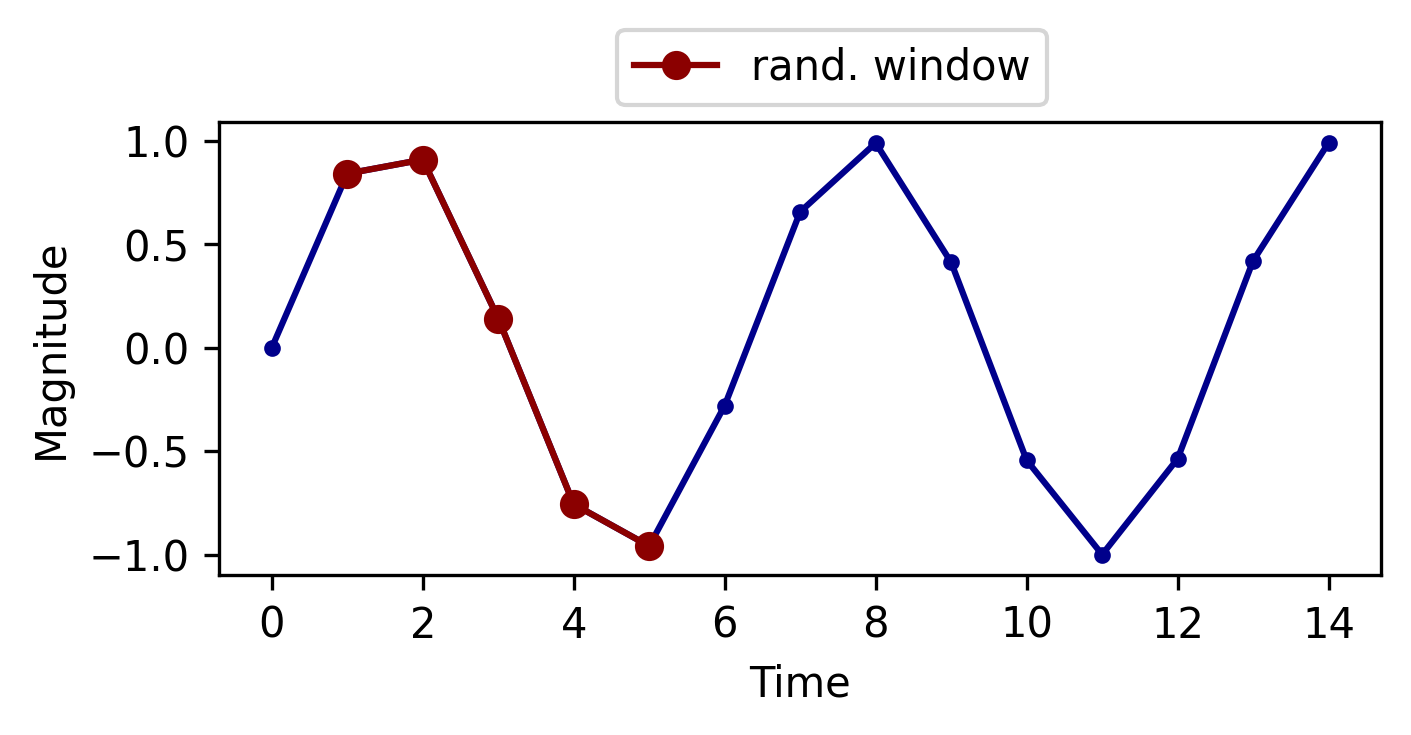

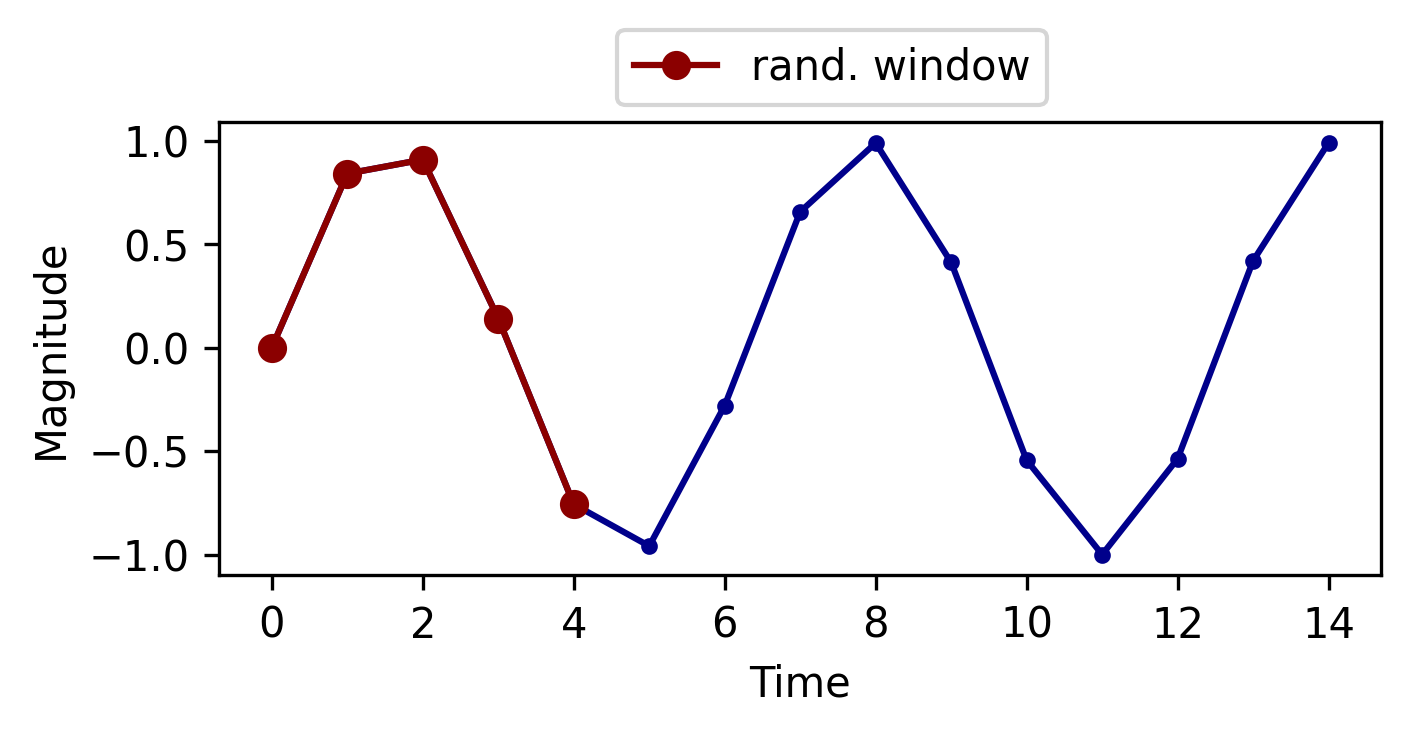

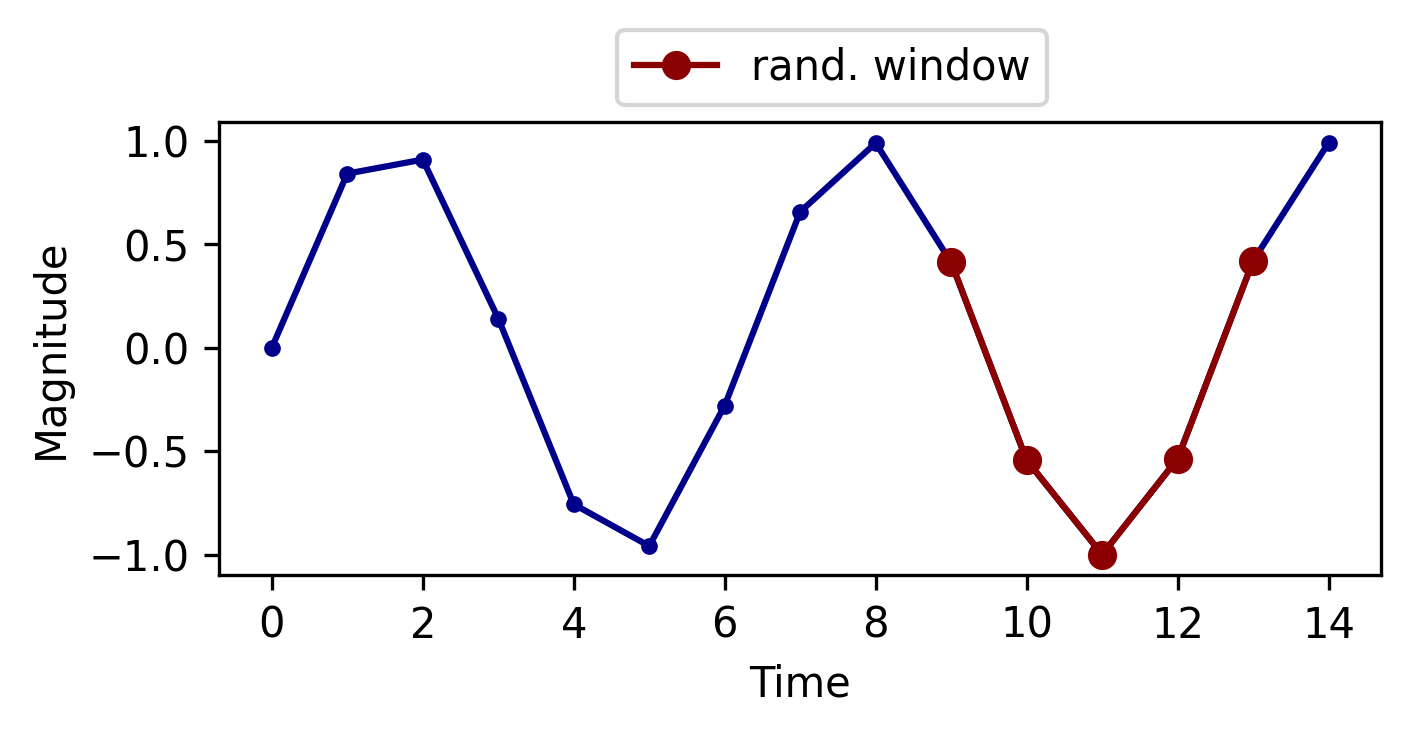

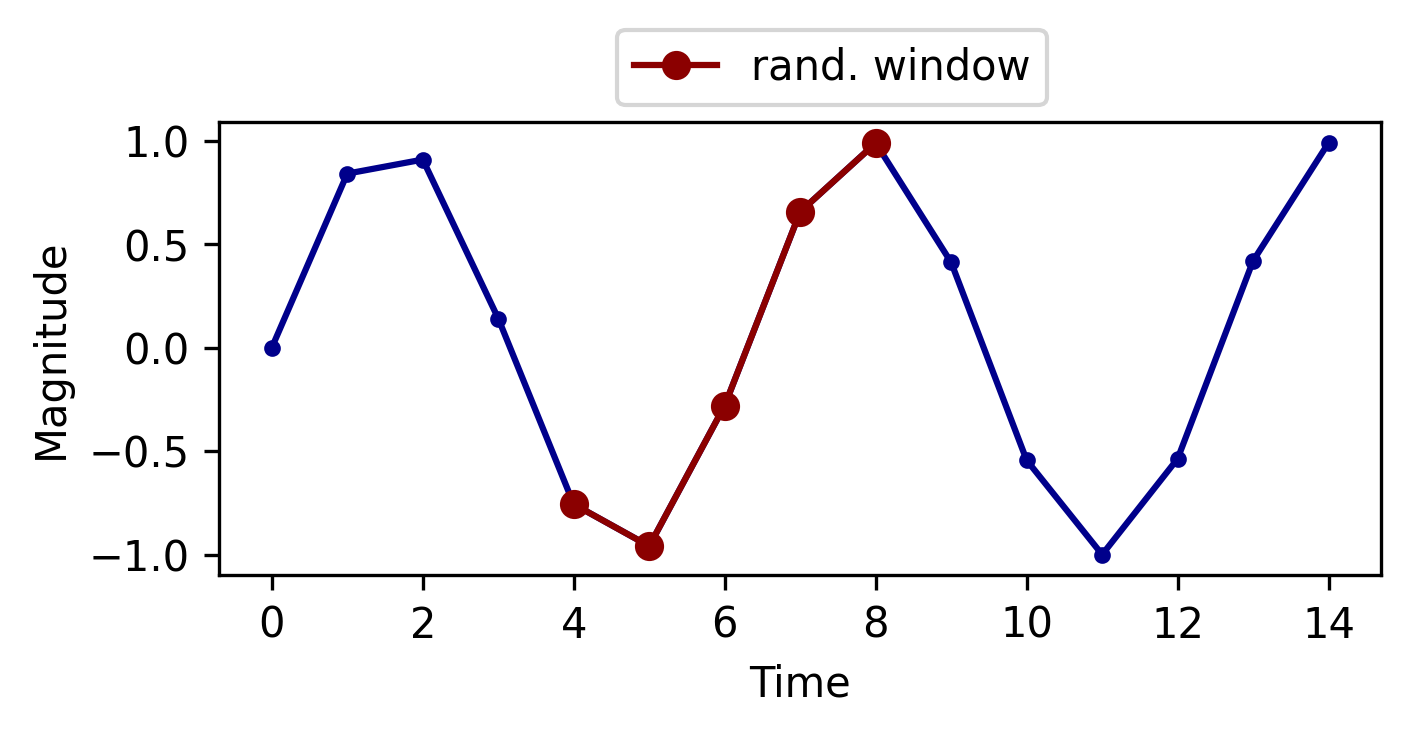

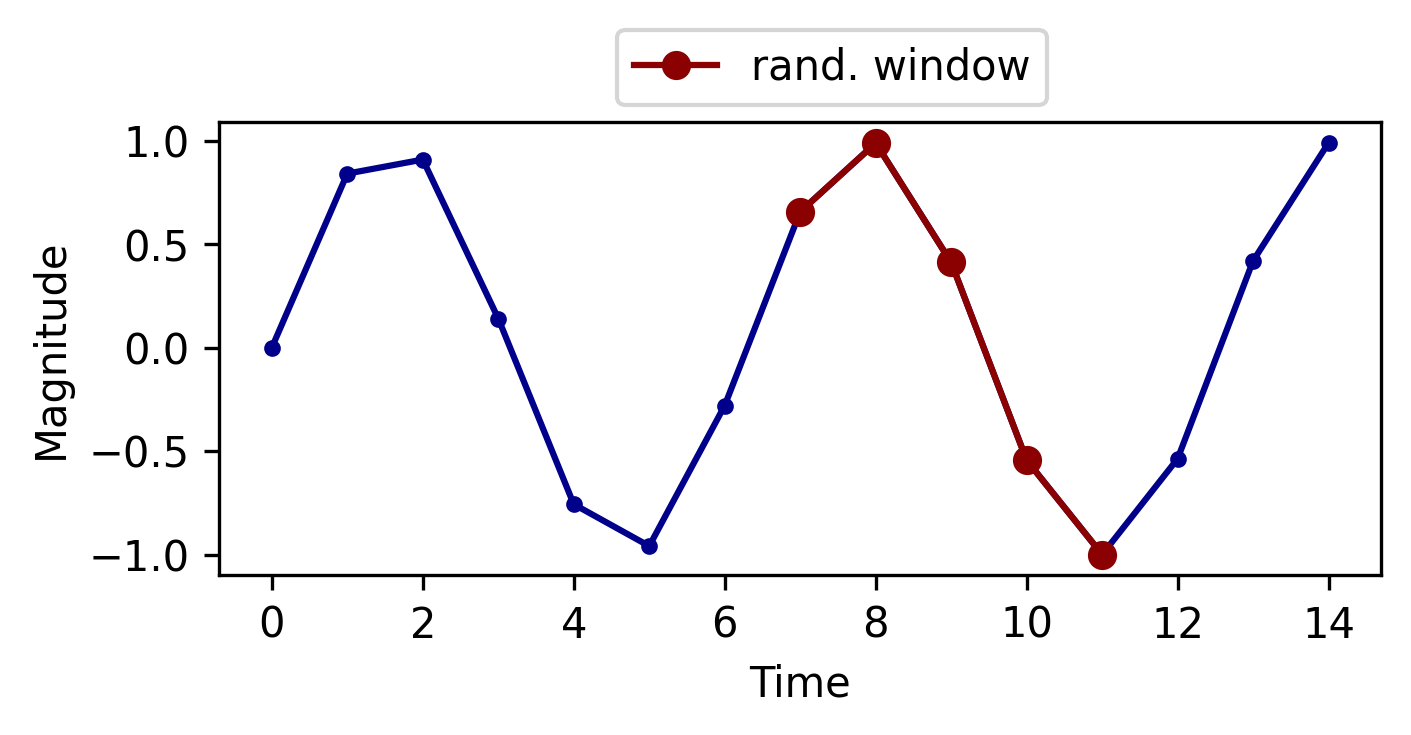

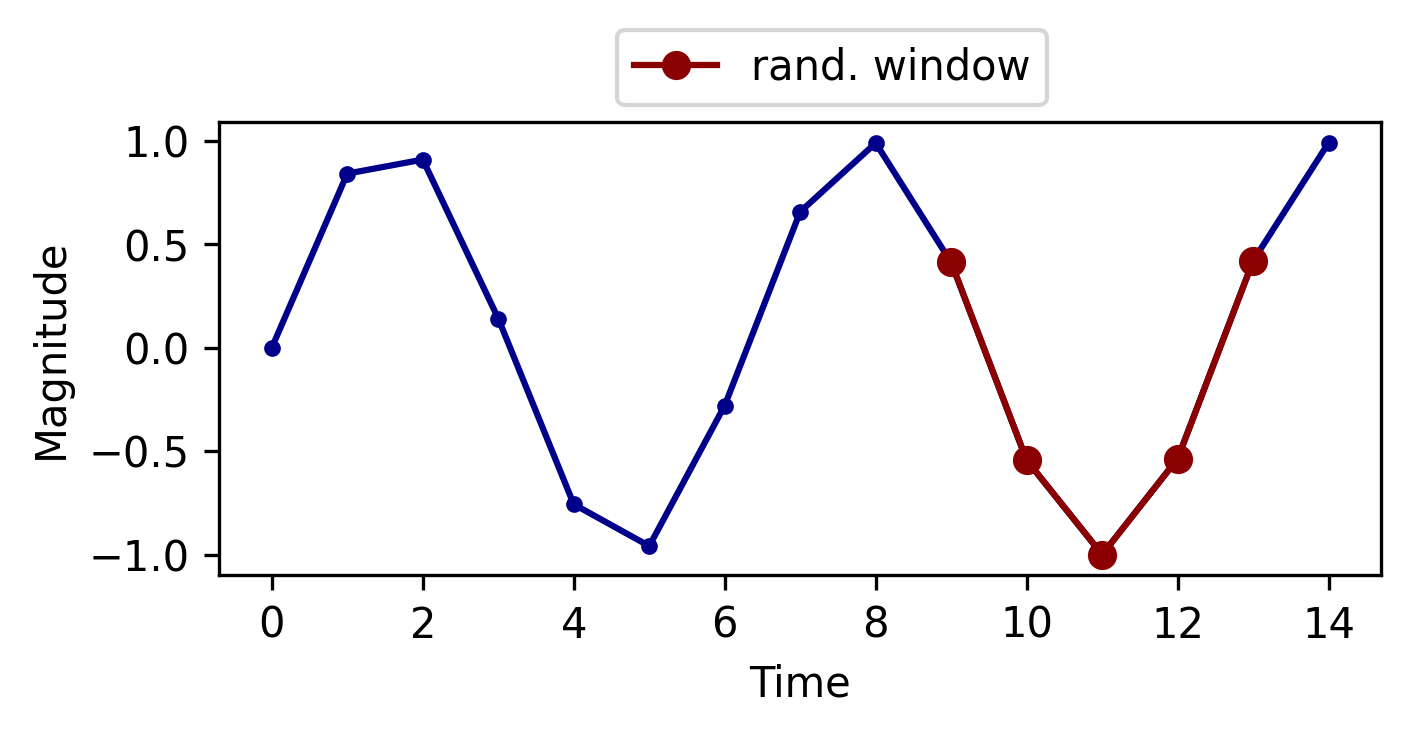

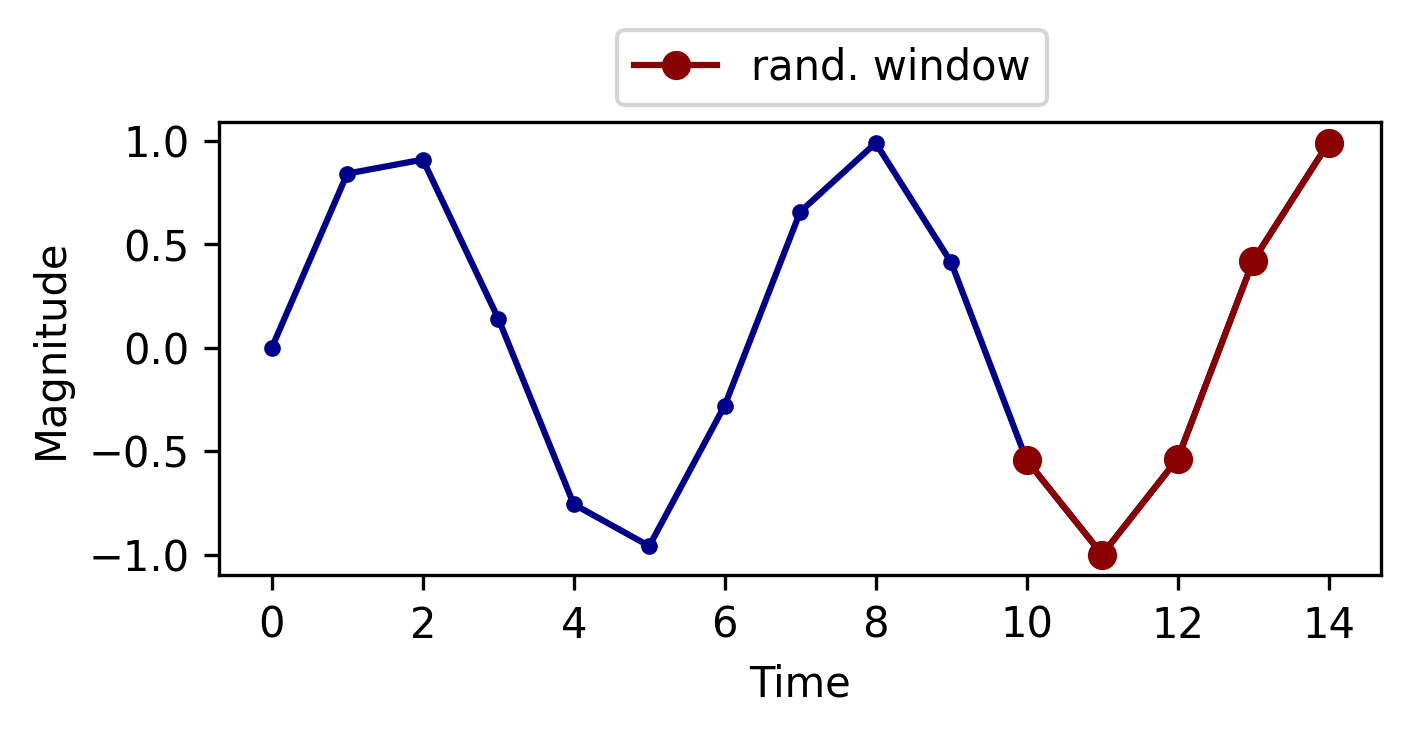

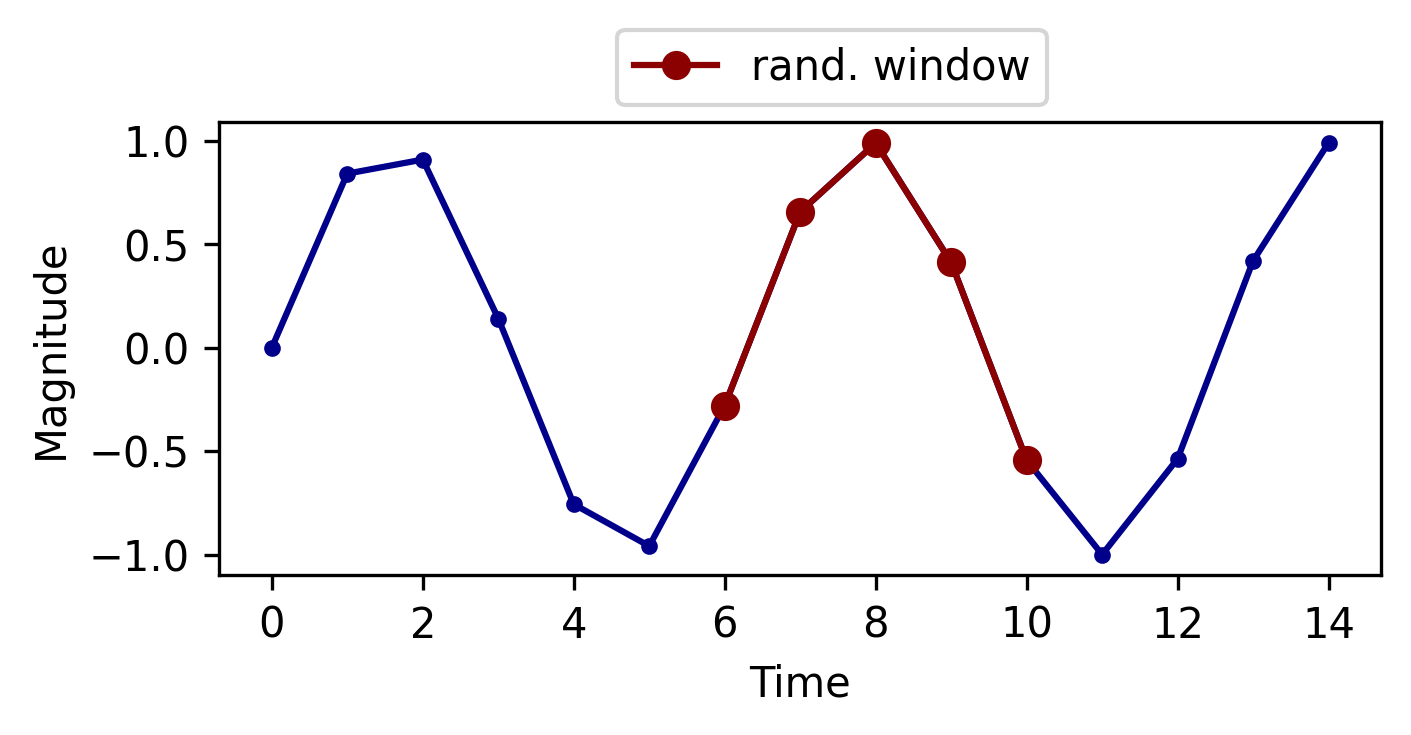

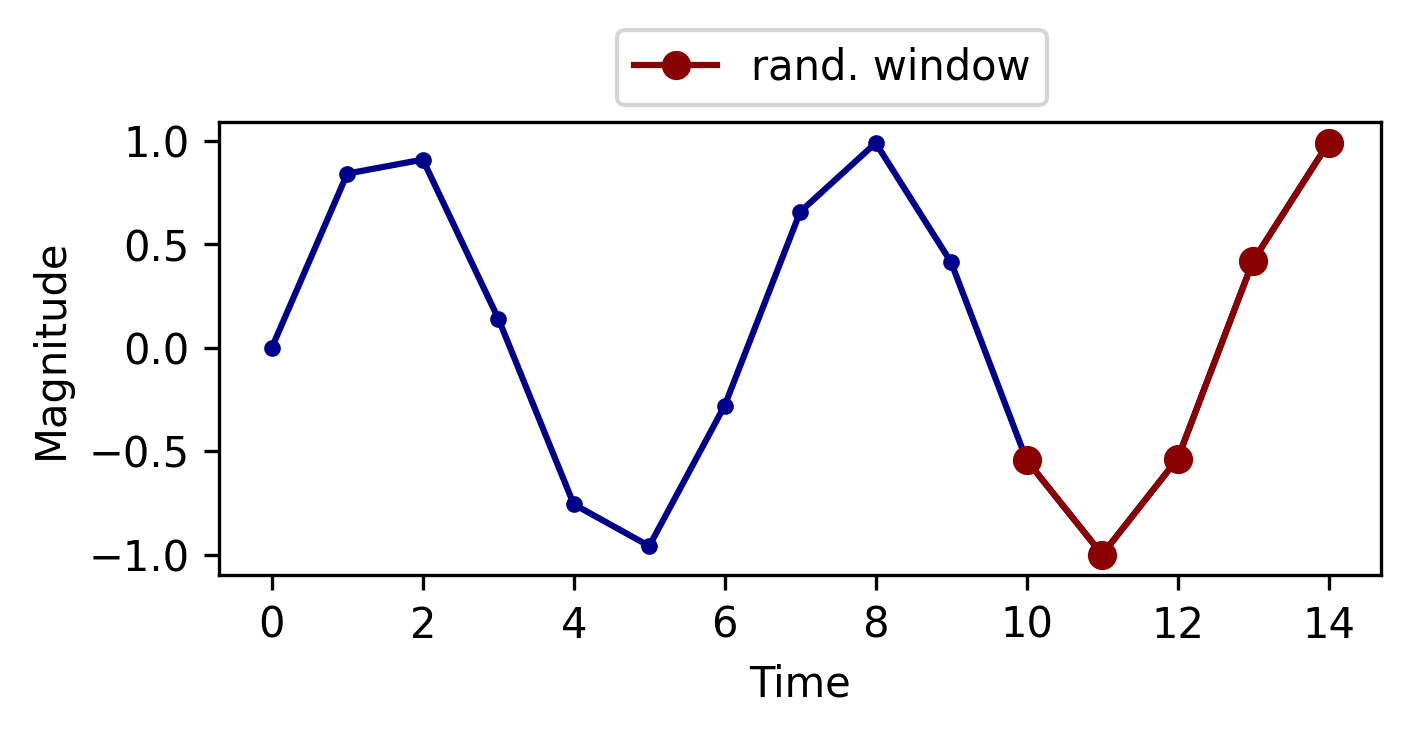

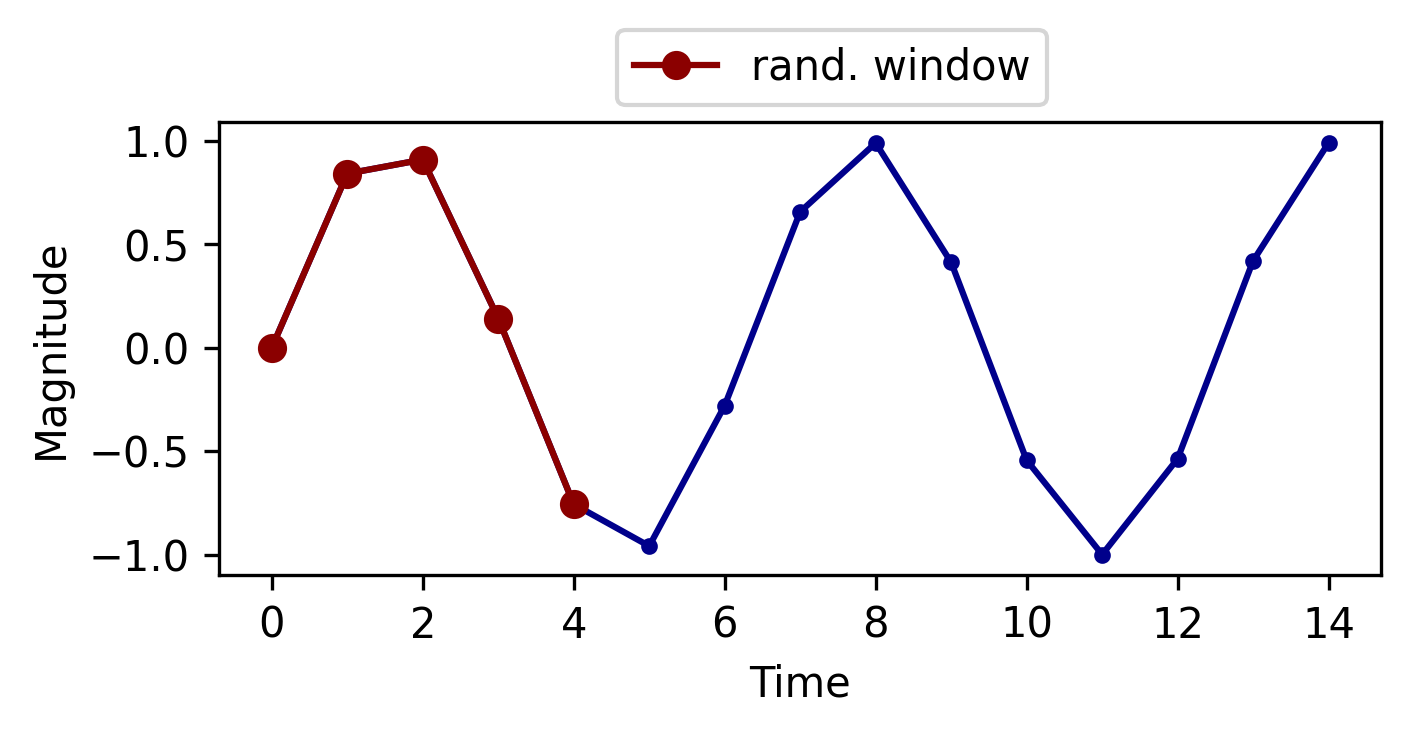

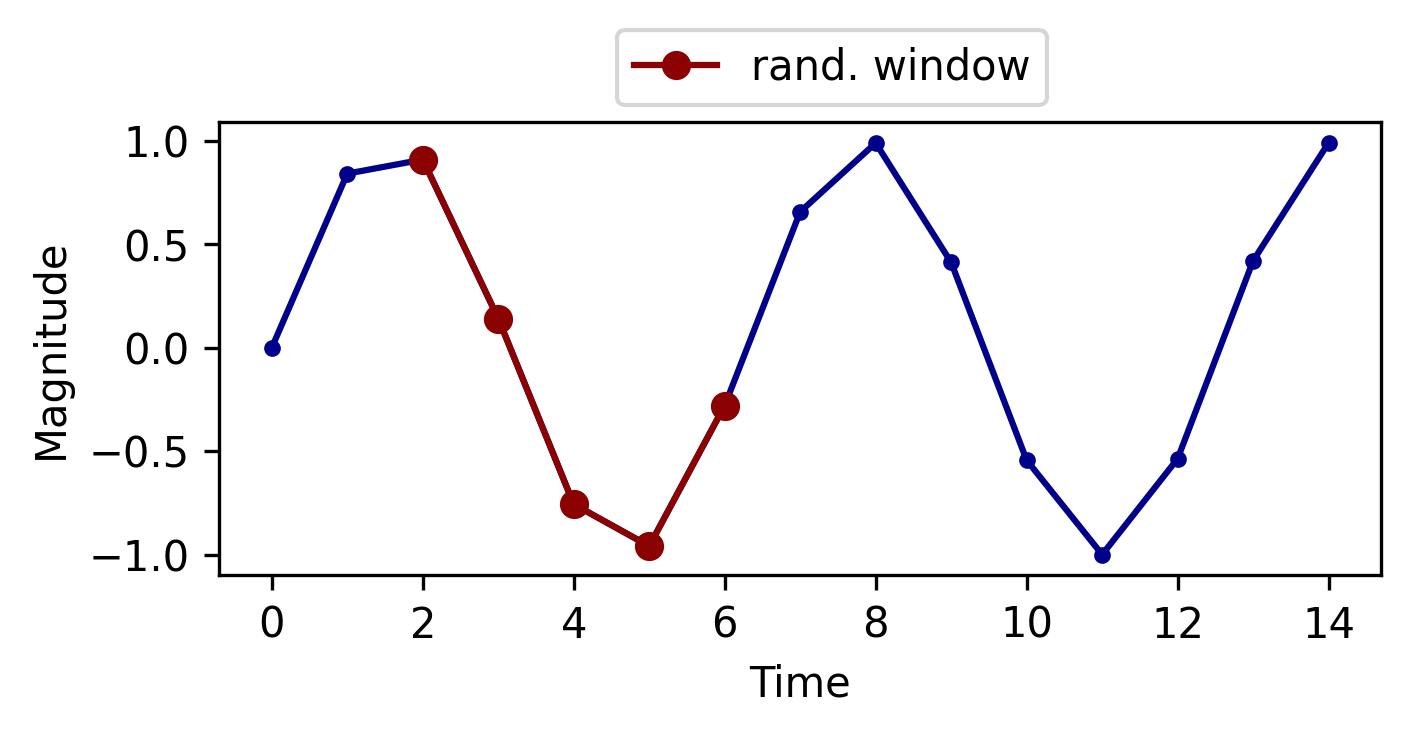

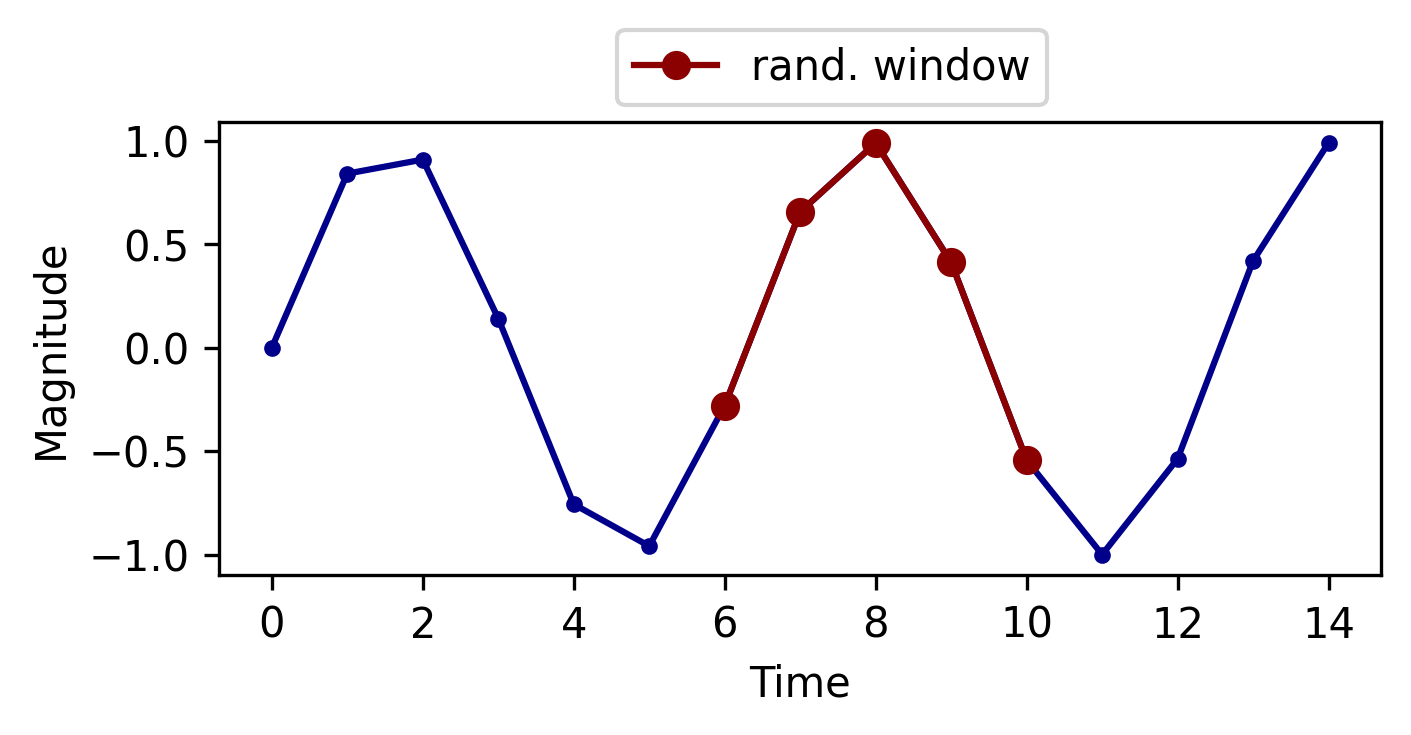

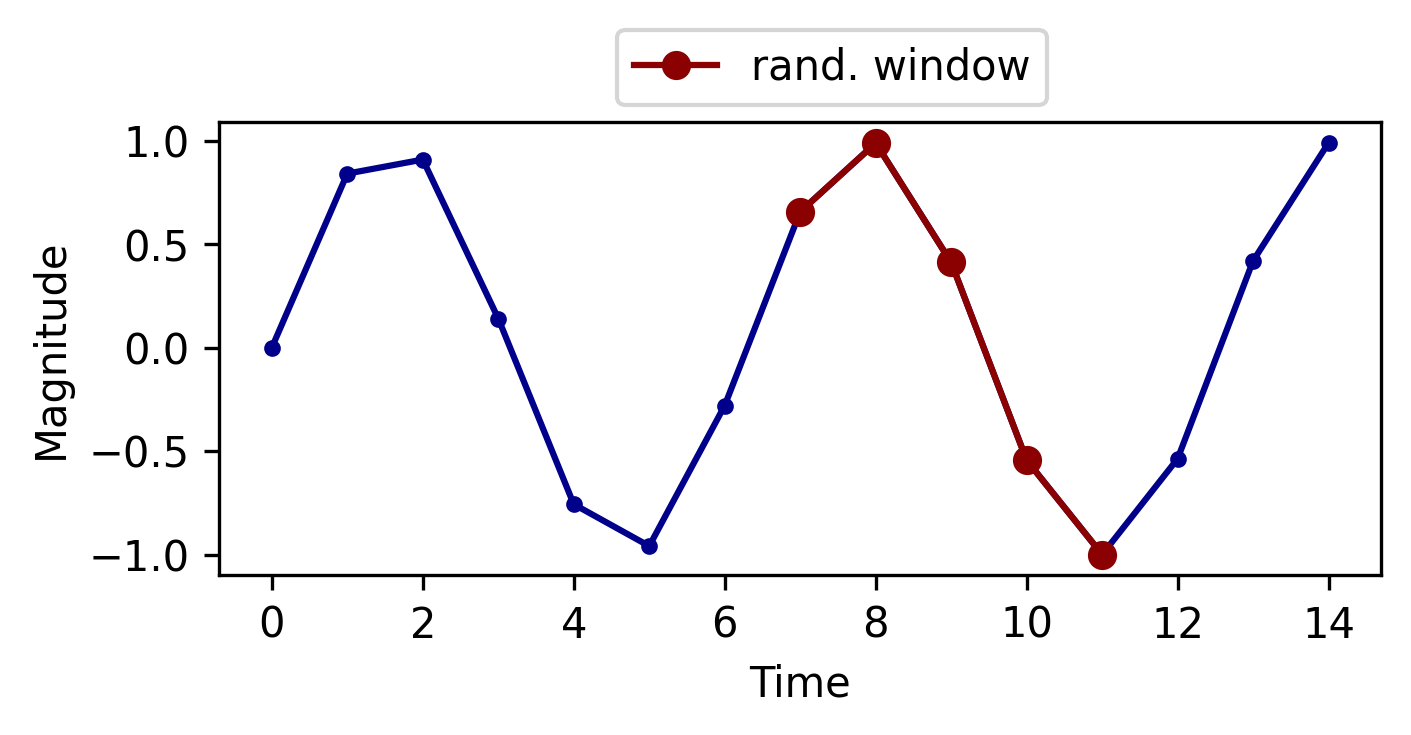

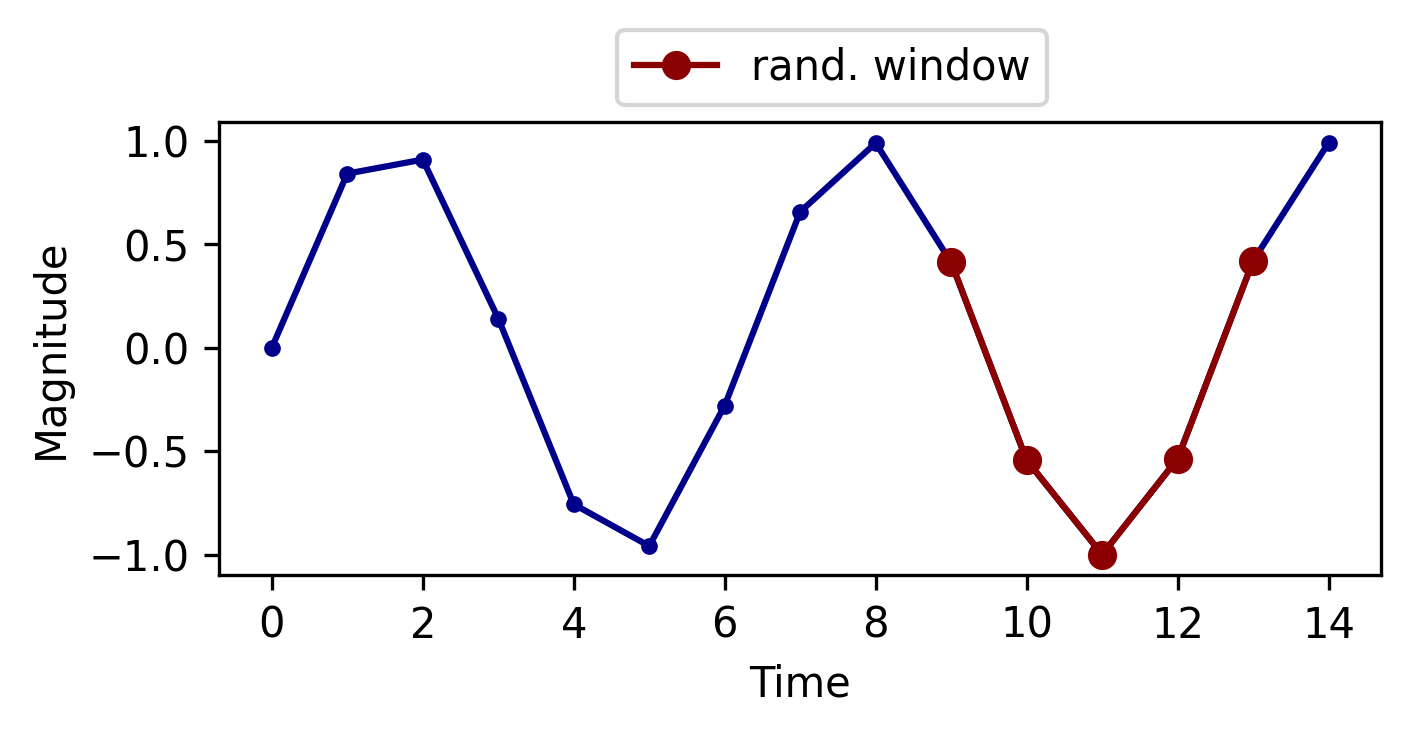

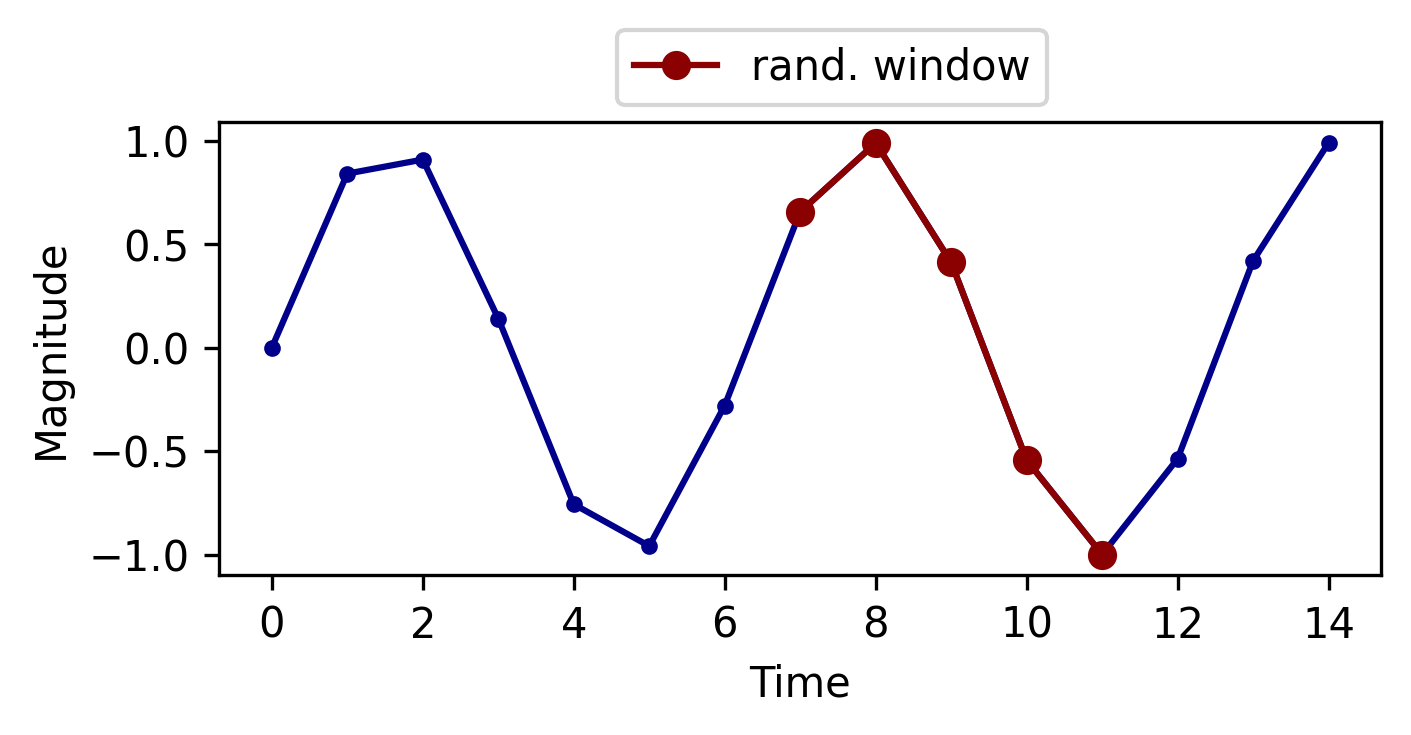

In [12]:
for i in range(20):
    plt.figure(figsize=(5,2), dpi=300)
    plt.plot(sequence[:, 0], sequence[:, 1], marker='.', color='darkblue')
    sample = sample_lc(sequence, max_obs=5)
    plt.plot(sample[:, 0], sample[:, 1], marker='o', color='darkred', label='rand. window')
    plt.xlabel('Time')
    plt.ylabel('Magnitude')
    plt.legend(bbox_to_anchor=(.73, 1.25))
    plt.savefig('./presentation/figures/sampling/{}.png'.format(i), bbox_inches='tight', dpi=300)

# sliding window

In [141]:
import tensorflow as tf 

from core.data import pretraining_records

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [142]:
batches = pretraining_records('./data/records/alcock/train', 
                             16, 
                             shuffle=False, 
                             max_obs=200,
                             msk_frac=0.5, 
                             rnd_frac=0.2, 
                             same_frac=0.2)

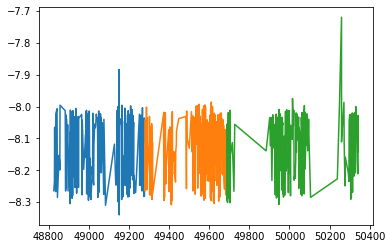

In [143]:
for batch in batches:
    plt.plot(batch[0][:, 0], batch[0][:, 1])
    plt.plot(batch[1][:, 0], batch[1][:, 1])
    plt.plot(batch[2][:, 0], batch[2][:, 1])
    break